In [145]:
import argparse
import json
import sys, os
import pandas as pd
import numpy as np

In [187]:
def print_compare_table(sim_res, sim_res2, NRMSE=False):
    cmp_list = {
        'gmem_tot_reqs': 'L1 Reqs',
        'gmem_tot_sectors': 'L1 Sectors',
        'l1_hit_rate': 'L1 Hit Rate',
        'l1_hit_rate_g': 'L1 Hit Rate Global',
        'l1_hit_rate_ldg': 'L1 Hit Rate Global Load',
        # 'l1_hit_rate_stg': 'L1 Hit Rate Global Store',
        'l2_ld_trans': 'L2 Reads',
        'l2_st_trans': 'L2 Writes',
        'l2_tot_trans': 'L2 Total Reqs',
        'l2_hit_rate': 'L2 Hit Rate',
        'l2_hit_rate_ld': 'L2 Read Hit Rate',
        # 'l2_hit_rate_st': 'L2 Write Hit Rate',
        'dram_ld_trans': 'DRAM Reads',
        'dram_st_trans': 'DRAM Writes',
        'dram_tot_trans': 'DRAM Total Reqs',
    }
    def to_percentage(x):
        return "{:.2%}".format(x)
    old_model_MAE = df_sim1[('all', 'MAE')].apply(to_percentage)
    new_model_MAE = df_sim2[('all', 'MAE')].apply(to_percentage)
    old_model_corr = df_sim1[('all', 'corr')].apply(to_percentage)
    new_model_corr = df_sim2[('all', 'corr')].apply(to_percentage)
    
    if not NRMSE:
        merge_df = pd.concat([old_model_MAE, new_model_MAE, old_model_corr, new_model_corr], axis=1)
        merge_df.columns = pd.MultiIndex.from_tuples([('MAE', 'Old Model'), ('', 'New Model'), ('Correlation', 'Old Model'), ('', 'New Model')])
    else:
        old_model_NRMSE = df_sim1[('all', 'NRMSE')].apply(to_percentage)
        new_model_NRMSE = df_sim2[('all', 'NRMSE')].apply(to_percentage)
        merge_df = pd.concat([old_model_MAE, new_model_MAE, old_model_corr, new_model_corr, old_model_NRMSE, new_model_NRMSE], axis=1)
        merge_df.columns = pd.MultiIndex.from_tuples([('MAE', 'Old Model'), ('', 'New Model'), ('Correlation', 'Old Model'), ('', 'New Model'), ('NRMSE', 'Old Model'), ('', 'New Model')])
    select_df = merge_df.loc[cmp_list.keys()].rename(index=cmp_list)
    return merge_df,select_df

In [190]:
# sim_res = 'memory_ppt-gpu_CL128.xlsx'
# sim_res = 'memory_ppt-gpu_CL32.xlsx'
# sim_res2 = 'memory_simulator.xlsx'

sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32_34.xlsx'
sim_res2 = 'memory_titanv_TITANV_simulator_base_34.xlsx'

sim_res = 'memory_titanv_A100-40G_ppt-gpu_base_CL32_34.xlsx'
sim_res2 = 'memory_titanv_A100-40G_simulator_base_34.xlsx'
output_dir = 'paper_draw'

In [191]:
df_sim1 = pd.read_excel(sim_res, sheet_name="apps_summary", header=[0, 1], index_col=0)
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps_summary", header=[0, 1], index_col=0)
_, select_df = print_compare_table(df_sim1, df_sim2, NRMSE=True)
select_df

,MAE,,Correlation,,NRMSE,
,Old Model,New Model,Old Model,New Model,Old Model,New Model
L1 Reqs,9.21%,4.22%,99.99%,100.00%,38.40%,2.15%
L1 Sectors,15.31%,9.94%,99.99%,100.00%,47.67%,1.37%
L1 Hit Rate,11.66%,9.22%,99.28%,99.31%,7.95%,8.07%
L1 Hit Rate Global,11.63%,9.22%,99.28%,99.31%,7.95%,8.06%
L1 Hit Rate Global Load,11.38%,7.74%,99.63%,99.73%,5.91%,5.03%
L2 Reads,27.18%,26.59%,97.21%,99.20%,119.99%,27.89%
L2 Writes,61.88%,62.69%,99.52%,99.37%,88.19%,116.02%
L2 Total Reqs,40.11%,41.31%,99.58%,99.48%,63.33%,99.18%
L2 Hit Rate,41.20%,45.97%,5.38%,24.90%,55.73%,64.60%


In [170]:
from scripts.common import get_suite_info

In [162]:
def get_metric_df(df_sim1, df_sim2, metric):
    df1 = df_sim1[['app', f"{metric}_hw", f"{metric}_sim"]]
    df2 = df_sim2[f"{metric}_sim"]
    df_new = pd.concat([df1, df2], axis=1)
    
    # rename columns
    df_new.columns = ['APP', 'HW', 'PPT-GPU-Mem', 'Ours']
    
    app_rename_map = {}
    for app in df_new['APP']:
        abbr = suite_info['map'][app][-1]
        app_rename_map[app] = abbr
    df_new['APP'] = df_new['APP'].map(app_rename_map)
    df_new = df_new.set_index('APP')
    return df_new
def draw_bar(df_sim1, df_sim2, draw_list):
    for metric in draw_list:
        print(f"Drawing {metric}...")
        df_metric = get_metric_df(df_sim1, df_sim2, metric)

        # df_metric.plot.bar()
        # save to excel
        with pd.ExcelWriter(os.path.join(output_dir, f"{metric}.xlsx"), engine='xlsxwriter') as writer:
            df_new.to_excel(writer, sheet_name=metric, index=False)

In [163]:
df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")

In [164]:
draw_list = ["l1_hit_rate", "l1_hit_rate_g", "l1_hit_rate_ldg", "l2_hit_rate", "l2_hit_rate_ld",
            "l2_ld_trans","l2_st_trans","l2_tot_trans","dram_ld_trans","dram_st_trans","dram_tot_trans",
            "gmem_ld_diverg"]
# draw_bar(df_sim1, df_sim2, draw_list)

In [172]:
df = get_metric_df(df_sim1, df_sim2, 'l2_hit_rate_ld')
df

,HW,PPT-GPU-Mem,Ours
APP,,,
BTREE,0.609950,0.818888,0.464322
BP,0.183950,0.714999,0.058891
BFS,0.615519,0.440241,0.092453
BFS,0.543120,0.362337,0.148130
BFS,0.501004,0.278544,0.049605
CFD,0.388367,0.280273,0.402736
DWT2D,0.368840,0.316985,0.260638
GS,0.646850,0.426974,0.000000
GS,0.453660,0.396347,0.000000


In [156]:
df2 = (df['PPT-GPU-Mem'] - df['HW'])/df['HW']
df3 = (df['Ours'] - df['HW'])/df['HW']

In [157]:
df4 = pd.concat([df2, df3], axis=1)

In [158]:
df4

,0,1
APP,,
BTREE,2.610673e+00,0.642968
BP,-4.329964e-01,0.467507
BFS,inf,inf
BFS,inf,inf
BFS,3.004350e-01,2.060783
CFD,1.329669e+01,19.648437
DWT2D,inf,inf
GS,inf,inf
GS,inf,inf


<Axes: xlabel='APP'>

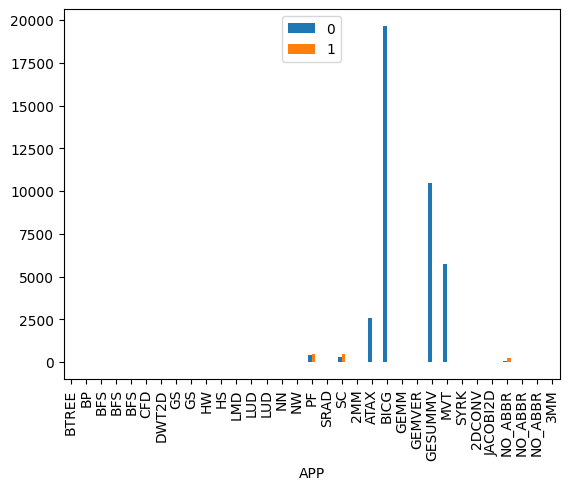

In [159]:
df4.plot.bar()

<Axes: xlabel='APP'>

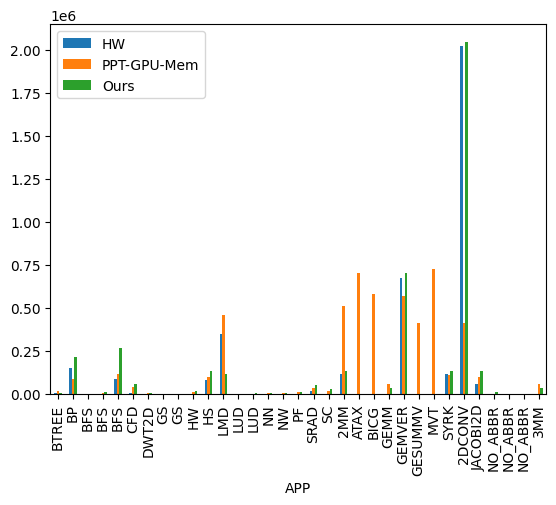

In [160]:
df.plot.bar()